# Modello locale di illuminazione

Prima di discutere del Ray Tracing bisogna introdurre un modello locale di illuminazione in cui il colore e l'intensità luminosa di un punto su una superficie dipendono solo dalle fonti luminose e dalle caratteristiche del materiale della superficie. Questo modello è sia molto efficiente per illuminazione real-time (come nei videogame) che rappresenta la base del ray tracing.


## Luce ambientale

Il termine più semplice, una illuminazione di intensità costante in ogni punto della scena (in genere di bassa intensità). Questo termine permette di evitare che le ombre siano totalmente nere. 

$k_a$ è il coefficiente di riflessione per la luce ambientale e $L_a$ è la quantità di luce ambientale emessa dalla sorgente. 

(E' strano e controintuitivo pensare che ogni sorgente emette una diversa quantità di luce ambientale, diffusa e speculare, invece che un singolo tipo di luce, ma è un sacrificio necessario per utilizzare un modello di illuminazione locale).
    
\begin{equation}
I_a = k_{\mathrm{a}} L_{\mathrm{a}}
\end{equation}

## Luce diffusa

Una superficie che riflette la luce in maniera del tutto diffusa è una superficie così ruvida che l'angolo di riflessione della luce nel limite non dipende dall'angolo di incidenza (infatti una minuscola variazione dell'angolo di incidenza può portare a un angolo di riflessione del tutto diverso).


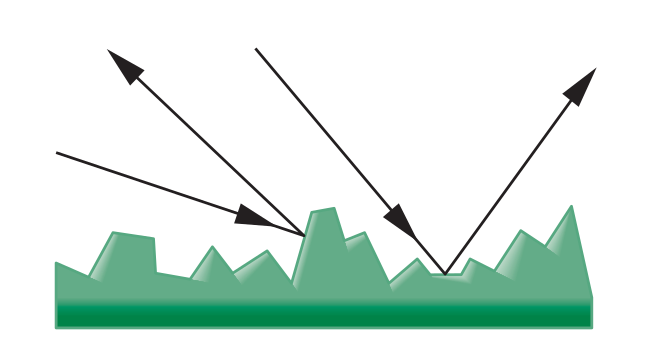

Una caratteristica molto particolare di queste superfici è che appaiono allo stesso modo per ogni osservatore equidistante, poichè emettono la stessa intensità luminosa in ogni direzione.

Quindi la luce emessa da una superficie di questo tipo dipende solo dal prodotto scalare tra il vettore normale della superficie $\bf{n}$ e il vettore della luce $\bf{l}$ poiché tanto più la luce è allineata con la normale tanta più energia per unità di superficie trasmetterà alla superficie (così come a mezzogiorno c'è più caldo che al tramonto).

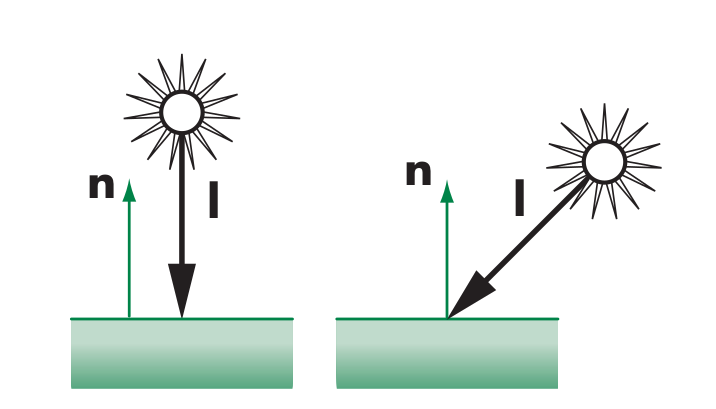

L'intensità di luce riflessa dalla superficie diminuisce nel mondo reale sulla base dell'inverso del quadrato della distanza tra fonte luminosa e superficie, ma in grafica si usa un polinomio di secondo grado al denominatore per maggiore flessibilità.

Infine teniamo conto che una luce dietro a una superficie ha un contributo nullo, non negativo, quindi invece di $\mathbf{l} \cdot \mathbf{n}$ avremo $\max (\mathbf{l} \cdot \mathbf{n}, 0)$

$k_d$ è il coefficiente di riflessione per la luce diffusa e $L_d$ è la quantità di luce diffusa emessa dalla sorgente. 

\begin{equation}
I_d = \frac{1}{a+b d+c d^2}(k_{\mathrm{d}} L_{\mathrm{d}} \max (\mathbf{l} \cdot \mathbf{n}, 0)
\end{equation}

## Luce speculare


La riflessione speculare è tipica degli oggetti con superfici molto lisce come ad esempio i metalli, dato $\bf{r}$ il vettore di riflessione e $\bf{v}$ il vettore che indica la direzione dell'osservatore abbiamo che un materiale di questo tipo appare tanto più luminoso tanto più l'osservatore è allineato con il vettore di riflessione. Il coefficiente $\alpha$ è una proprietà del materiale che indica quanto la superficie è liscia, cresce al crescere della lisciezza della superficie e nel farlo concentra la riflessione della luce su un angolo solido minore.

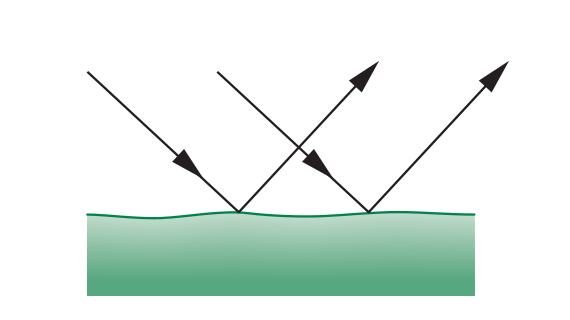

$k_r$ è il coefficiente di riflessione per la luce speculare e $L_r$ è la quantità di luce speculare emessa dalla sorgente. 

\begin{equation}
I_s = \frac{1}{a+b d+c d^2}(k_{\mathrm{s}} L_{\mathrm{s}} \max ( (\mathbf{r} \cdot \mathbf{v})^\alpha, 0)
\end{equation}


## Luce (modello di Phong)

La somma di questi termini già porta ad un'ottima approssimazione locale del processo di illuminazione che è molto efficiente a livello computazionale e quindni molto usata nei videogame che necessitano di grafica in tempo reale.

L'intensità luminosa di punto di una superficie (con questo conto che va ripetuto per ognuna della fonti luminose $L$ e per ognuno dei 3 colori fondamentali RGB, sommando ognuno di questi contributi) può essere approssimata come:

\begin{equation}
I=\frac{1}{a+b d+c d^2}\left(k_{\mathrm{d}} L_{\mathrm{d}} \max (\mathbf{l} \cdot \mathbf{n}, 0)+k_{\mathrm{s}} L_{\mathrm{s}} \max \left((\mathbf{r} \cdot \mathbf{v})^\alpha, 0\right)\right)+k_{\mathrm{a}} L_{\mathrm{a}}
\end{equation}

# Ray Tracing

Il Ray Tracing è la naturale generalizzazione del modello di Phong: invece di accettare questa prima approssimazione data dall'equazione sopra come il valore finale dell'intensità luminosa di quel punto, si itera, assegnando a quel punto una luminosità che è una media pesata della luminosità locale ottenuta in questo modo e la luminosità ottenuta dai successivi rimbalzi di un raggio di luce, seguendo un processo ricorsivo.

Mentre i raggi di luce partono in realtà dalla (o dalle) fonti luminose, seguire questo approccio porterebbe a un grande spreco di risorse poiché solo una minima parte di questi colpirebbero l'osservatore (matematicamente 0 se l'osservatore è un punto), quindi si sfrutta la simmetria del problema e si assume che i raggi di luce partano dall'osservatore.

# Implementazione

## Importiamo le librerie e definiamo le dimensioni dello schermo (w, h)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

w = 400
h = 300

## Semplificazione: solo piani e sfere come oggetti

Come abbiamo visto nella discussione teorica prima, è necessario calcolare la distanza dell'osservatore (che è posizionato all'origine del raggio di luce) lungo il raggio di luce (rappresentati come rette in forma parametrica, con un punto di origine e un vettore direzione) con ognuno degli oggetti presenti nella scena. Ogni oggetto può essere approssimato come un insieme di porzioni di piano che lo approssimano, quindi limitarsi solo a piani e sfere non è una limitazione grave come sembra, quindi, per semplicità, questo esempio conterrà solo piani e sfere come oggetti su cui simulare l'illuminazione.

## Importanza del calcolo della distanza

L'intensità della luce diminuisce all'aumentare della distanza.

Inoltre, il raggio di luce colpirà la superficie più vicina, quindi è necessario scrivere delle funzioni che daranno come output la distanza tra l'origine del raggio di luce e ogni oggetto al fine di capire su quali di questi il raggio di luce rimbalzerà (cioè quale superficie è la prima lungo il percorso del raggio di luce, ovvero quella con distanza minore).

## Distanza dall'origine di una semiretta (raggio di luce) a un piano lungo la semiretta

Data una (semi)retta (che rappresenta il nostro raggio di luce) in forma parametrica, con $\bf{O}$ punto iniziale, $X$ vettore contente le tre incognite (x,y,z), e $\bf{D}$ vettore di direzione, ovvero per ogni valore del parametro libero $t$ il punto corrispondente della retta sarà $\bf{O} + t\bf{D}$:

\begin{equation}
retta: \textbf{X} = \textbf{O} + t \textbf{D}
\end{equation}

E dato un piano a cui appartiene il punto $\bf{P}$ con vettore normale $\bf{N}$, si ha dato $\bf{X} - \bf{P}$ vettore arbitrario giacente nel piano, che i punti che fanno parte del piano sono quelli per cui:

\begin{equation}
piano: (\textbf{X - P}) \textbf{N} = 0
\end{equation}

Se il prodotto scalare è nullo due vettori sono normali tra di loro, e il vettore N deve essere normale con uno qualsiasi dei vettori giacenti nel piano.

Per trovare la distanza tra il punto $\bf{O}$ e il piano lungo la retta dobbiamo trovare il punto di intersezione e calcolare la distanza del punto di intersezione dal punto $\bf{O}$.

Per trovare il punto di intersezione è sufficiente risolvere il sistema retta-piano per t e sostituire il t trovato (che chiamiamo $t^{*}$) nell'equazione della retta.


\begin{equation}
    \begin{cases}
retta: \textbf{X} = \textbf{O} + t^{*} \textbf{D}\\
piano: (\textbf{X - P}) \textbf{N} = 0\\
    \end{cases}\,.
\end{equation}


\begin{equation}
((\textbf{O} +  t^{*} \textbf{D}) - \textbf{P}) \textbf{N} = 0
\end{equation}

\begin{equation}
\textbf{O} \textbf{N} +  t^{*} \textbf{D} \textbf{N} - \textbf{P} \textbf{N} = 0
\end{equation}


\begin{equation}
 t^{*} \textbf{D} \textbf{N}  = \textbf{P} \textbf{N} - \textbf{O} \textbf{N}
\end{equation}



\begin{equation}
 t^{*}   = \frac{\textbf{P} \textbf{N} - \textbf{O} \textbf{N}}{\textbf{D} \textbf{N}}
\end{equation}


\begin{equation}
 t^{*}   = \frac{(\textbf{P} - \textbf{O})\textbf{N}}{\textbf{D} \textbf{N}}
\end{equation}

Nota bene: stiamo parlando di prodotti scalari quindi non possiamo semplificare $\bf{N}$ da sopra e sotto!

Infine calcoliamo la distanza $d$ dal punto della retta individuato da $t = t^*$ e l'origine del raggio di luce $\bf{O}$.

\begin{equation}
 d = |(\textbf{O} + t^{*} \textbf{D}) - \textbf{O}| 
\end{equation}

\begin{equation}
 d = |t^{*} \textbf{D}| 
\end{equation}

Tenendo conto che il vettore $\bf{D}$ è normalizzato (lunghezza = 1):

\begin{equation}
 d = |t^{*}| 
\end{equation}


Ora siamo quasi pronti per trasformare queste equazioni in codice sfruttando la funzione `np.dot` che svolge prodotti scalari. Dobbiamo solo tenere a mente due considerazioni:

1. Se il denominatore è piccolo si potrebbero avere problemi numerici, quindi se è troppo piccolo (cioè se retta e piano sono quasi paralleli), assumiamo per semplicità che non ci sia intersezione (intersezione a infinito).

2. Il raggio di luce è una SEMI-retta, quindi dobbiamo calcolare se l'intersezione avviene dal lato giusto rispetto all'origine del raggio di luce $\bf{O}$ (cioè $t^* > 0$) o sbagliato (cioè $t^* < 0)$, se l'intersezione avviene dal lato sbagliato allora non c'è intersezione (intersezione a infinito).


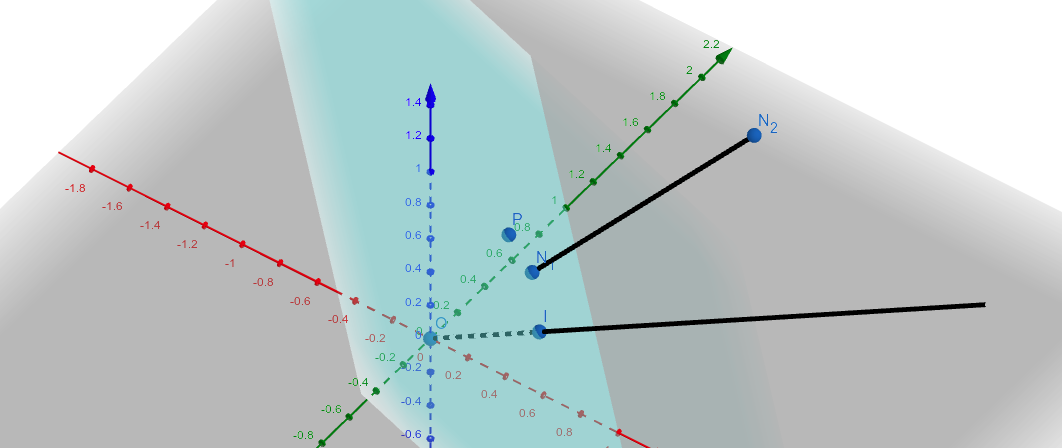

Il punto $O$ è $O$: l'origine della semiretta (raggio di luce).

Il vettore $\overline{OI}$ è $D$: la direzione della semiretta.

Il punto $P$ è $P$: un punto qualsiasi sul piano.

Il vettore $\overline{N_1 N_2}$ è $N$: il vettore normale del piano.

In [ ]:
def intersect_plane(O, D, P, N):
    # Return the distance from O to the intersection of the ray (O, D) with the 
    # plane (P, N), or +inf if there is no intersection.
    # O and P are 3D points, D and N (normal) are normalized vectors.
    denom = np.dot(D, N)
    if np.abs(denom) < 1e-6:
        return np.inf
    d = np.dot(P - O, N) / denom
    if d < 0:
        return np.inf
    return d

## Distanza dall'origine di una semiretta (raggio di luce) a una sfera lungo la semiretta

Definendo la (semi)retta come prima:

In forma parametrica, con $\bf{O}$ punto iniziale, $X$ vettore contente le tre incognite (x,y,z), e $\bf{D}$ vettore di direzione, ovvero per ogni valore del parametro libero $t$ il punto corrispondente della retta sarà $\bf{O} + t\bf{D}$:

\begin{equation}
retta: \textbf{X} = \textbf{O} + t \textbf{D}
\end{equation}

E una sfera con centro $\bf{S}$ e raggio R:

\begin{equation}
sfera: |\textbf{X} - \textbf{S}|^2 = R^2
\end{equation}

Possiamo trovare l'intersezione tra la retta e la sfera con un procedimento analogo a quello svolto per il piano, con l'unica complicazione del dover risolvere una equazione di secondo grado invece che di primo:



\begin{equation}
    \begin{cases}
retta: \textbf{X} = \textbf{O} + t^{*} \textbf{D}\\
sfera: |\textbf{X} - \textbf{S}|^2 = R^2
    \end{cases}\,.
\end{equation}

\begin{equation}
|(\textbf{O} + t^{*} \textbf{D}) - \textbf{S}|^2 = R^2
\end{equation}

Ricordando che la norma al quadrato (la lunghezza al quadrato) di un vettore è uguale al prodotto scalare del vettore con se stesso:


\begin{equation}
((\textbf{O} + t^{*} \textbf{D}) - \textbf{S})((\textbf{O} + t^{*} \textbf{D}) - \textbf{S}) = R^2
\end{equation}

Abbiamo, applicando la proprietà distributiva del prodotto scalare sulla somma e della simmetria del prodotto scalare e raccogliendo i termini che sono moltiplicati per la stessa potenza di $t^*$:

\begin{equation}
{t^{*}}^{2} (\textbf{D} \textbf{D}) + t^{*} (2 (\textbf{D} ( \textbf{O} - \textbf{S}) ) ) + (\textbf{O}\textbf{O} - 2 \textbf{O} \textbf{S} + \textbf{S} \textbf{S} - R) = 0
\end{equation}

Ricordando che il risultato di un prodotto scalare è uno scalare, l'equazione quì sopra è una semplice equazione quadratica scalare, risolvendola si troverà il valore di $t^*$ per cui retta e sfera si intersecano, dopodiché come visto nella sezione precedente la distanza sarà semplicemente:

\begin{equation}
d = |t^*|
\end{equation}

Prima di implementare questo nel codice teniamo presenti tre considerazioni:

1. Non sempre una retta a caso interseca una sfera a caso, in questo caso (ovvero quando il determinante è minore di zero) non c'è intersezione: (intersezione a infinito).
2. Se la retta interseca la sfera ci saranno (quasi) sempre due punti distinti  di intersezione, tra questi ci interessa quello più vicino, ovvero quello con $t$ minore.
3. Come nella sezione di prima, se $t < 0$ allora l'intersezione è dal lato sbagliato, quindi non c'è intersezione (intersezione a infinito).

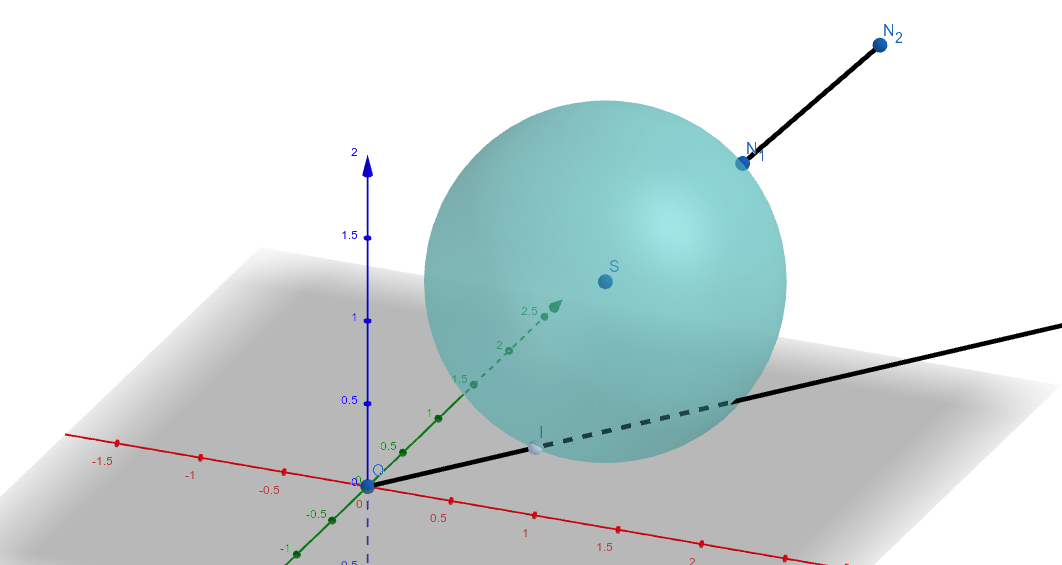

Il punto $O$ è $O$: l'origine della semiretta (raggio di luce).

Il vettore $\overline{OI}$ è $D$: la direzione della semiretta.

il punto $S$ è $S$: il centro della sfera.

Il vettore $\overline{N_1 N_2}$ è $N$: il vettore normale del piano.

In [ ]:
def intersect_sphere(O, D, S, R):
    # Return the distance from O to the intersection of the ray (O, D) with the 
    # sphere (S, R), or +inf if there is no intersection.
    # O and S are 3D points, D (direction) is a normalized vector, R is a scalar.
    a = np.dot(D, D)
    OS = O - S
    b = 2 * np.dot(D, OS)
    c = np.dot(OS, OS) - R * R
    disc = b * b - 4 * a * c
    if disc > 0:
        distSqrt = np.sqrt(disc)
        q = (-b - distSqrt) / 2.0 if b < 0 else (-b + distSqrt) / 2.0
        t0 = q / a
        t1 = c / q
        t0, t1 = min(t0, t1), max(t0, t1)
        if t1 >= 0:
            return t1 if t0 < 0 else t0
    return np.inf

## Funzioni di aiuto

Queste funzioni semplificano la scrittura del codice che segue ma non sono importanti a livello concettuale.

In [ ]:
def normalize(x):
    x /= np.linalg.norm(x)
    return x

def intersect(O, D, obj):
    if obj['type'] == 'plane':
        return intersect_plane(O, D, obj['position'], obj['normal'])
    elif obj['type'] == 'sphere':
        return intersect_sphere(O, D, obj['position'], obj['radius'])

def get_normal(obj, M):
    # Find normal.
    if obj['type'] == 'sphere':
        N = normalize(M - obj['position'])
    elif obj['type'] == 'plane':
        N = obj['normal']
    return N
    
def get_color(obj, M):
    color = obj['color']
    if not hasattr(color, '__len__'):
        color = color(M)
    return color

## Tracciare un raggio (singola iterazione)

Questa funzione svolge una singola iterazione del processo di Ray Tracing, può essere divisa nei seguenti passaggi:

1. Dato il nostro raggio di luce, per ogni oggetto nella scena, se l'oggeto interseca il raggio di luce, calcola la distanza dell'oggetto dall'osservatore e mantieni in memoria l'oggetto più vicino. Se invece il raggio di luce non colpisce nessun oggetto l'algoritmo finisce quì.

2. Determina se l'oggetto che il raggio di luce colpisce è in ombra, se lo è l'algoritmo finisce quì (l'oggetto non contribuirà all'illuminazione finale).

3. Applica il modello di illuminazione locale di Phong per ottenere una stima del contributo all'illuminazione dato da questo punto.

In [ ]:
def trace_ray(rayO, rayD):
    # 1
    # Find first point of intersection with the scene.
    t = np.inf
    for i, obj in enumerate(scene):
        t_obj = intersect(rayO, rayD, obj)
        if t_obj < t:
            t, obj_idx = t_obj, i
    # Return None if the ray does not intersect any object.
    if t == np.inf:
        return
    # Find the object.
    obj = scene[obj_idx]
    # Find the point of intersection on the object.
    M = rayO + rayD * t
    # Find properties of the object.
    N = get_normal(obj, M)
    color = get_color(obj, M)
    toL = normalize(L - M)
    toO = normalize(O - M)

    # 2
    # Shadow: find if the point is shadowed or not.
    l = [intersect(M + N * .0001, toL, obj_sh) 
            for k, obj_sh in enumerate(scene) if k != obj_idx]
    if l and min(l) < np.inf:
        return

    # 3
    # Phong local lightning model
    # Start computing the color.
    col_ray = ambient
    # Lambert shading (diffuse).
    col_ray += obj.get('diffuse_c', diffuse_c) * max(np.dot(N, toL), 0) * color
    # Phong shading (specular).

    # The original code used an optimization called the Blinn-Phong model
    # col_ray += obj.get('specular_c', specular_c) * max(np.dot(N, normalize(toL + toO)), 0) ** specular_k * color_light
    reflected = normalize(rayD - 2 * np.dot(rayD, N) * N)
    col_ray += obj.get('specular_c', specular_c) * max(np.dot(reflected, toO), 0) ** specular_k * color_light
    return obj, M, N, col_ray, reflected

## Costruzione della scena: posizionamento di sfere e piani e scelta dei parametri di illuminazione e della posizione della videocamera virtuale

In [ ]:
def add_sphere(position, radius, color):
    return dict(type='sphere',
                position=np.array(position), 
                radius=np.array(radius),
                color=np.array(color),
                reflection=.5
    )

In [ ]:
def add_plane(position, normal):
    return dict(
        type='plane',
        position=np.array(position), 
        normal=np.array(normal),
        color=lambda M: (color_plane0 
            if (int(M[0] * 2) % 2) == (int(M[2] * 2) % 2) else color_plane1),
        diffuse_c=.75,
        specular_c=.5,
        reflection=.25
    )


In [ ]:
# List of objects.
color_plane0 = 1. * np.ones(3)
color_plane1 = 0. * np.ones(3)
scene = [add_sphere([.75, .1, 1.], .6, [0., 0., 1.]),
         add_sphere([-.75, .1, 2.25], .6, [.5, .223, .5]),
         add_sphere([-2.75, .1, 3.5], .6, [1., .572, .184]),
         add_plane([0., -.5, 0.], [0., 1., 0.]),
    ]

# Light position and color.
L = np.array([5., 5., -10.])
color_light = np.ones(3)

# Default light and material parameters.
ambient = .05
diffuse_c = 1.
specular_c = 1.
specular_k = 10 # 50

depth_max = 5  # Maximum number of light reflections.
col = np.zeros(3)  # Current color.
O = np.array([0., 0.35, -1.])  # Camera.
Q = np.array([0., 0., 0.])  # Camera pointing to.
img = np.zeros((h, w, 3))

r = float(w) / h
# Screen coordinates: x0, y0, x1, y1.
S = (-1., -1. / r + .25, 1., 1. / r + .25)


## Ray Tracing ricursivo per ogni pixel

Il colore di ogni pixel sarà data dal colore che viene "accumulato" rimbalzando nella scena dal raggio che partendo dall'osservatore passa per quel pixel.

Il codice seguente si limita ad iterare la funzione `trace_ray` definita prima per ogni pixel tenendo conto dei cambiamenti di colore che vengono mano a mano accumulati.

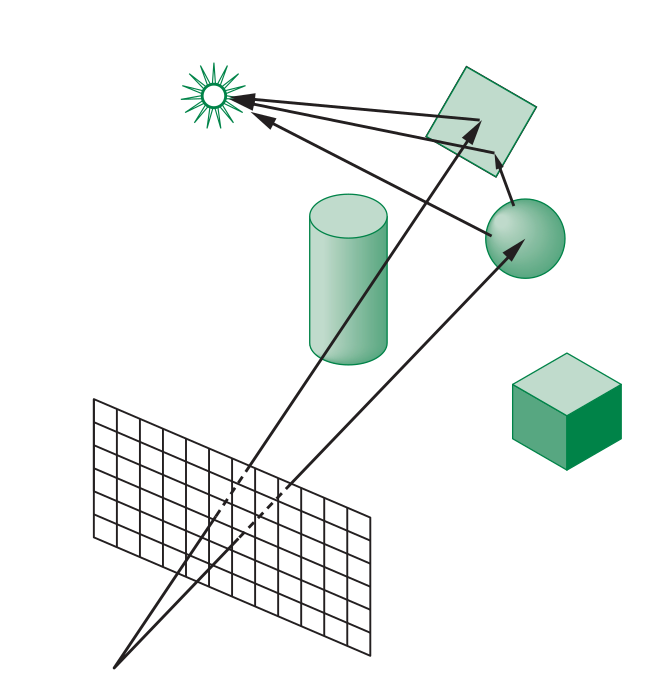

100% 

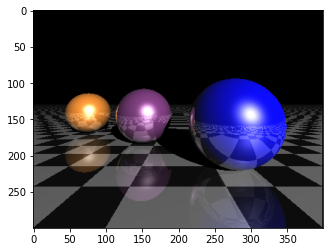

In [ ]:
from IPython.display import clear_output

# Loop through all pixels.
for i, x in enumerate(np.linspace(S[0], S[2], w)):
    if i % 40 == 0 or i == w-1:
        print( str(round(i / float(w) * 100))+"%", end=" ")
        plt.imshow(img)
        plt.show()
        clear_output(wait=True)

    for j, y in enumerate(np.linspace(S[1], S[3], h)):
        col[:] = 0
        Q[:2] = np.array([x, y])
        D = normalize(Q - O)
        depth = 0
        rayO, rayD = O, D
        reflection = 1.
        # Loop through initial and secondary rays.
        while depth < depth_max:
            traced = trace_ray(rayO, rayD)
            if not traced:
                break
            obj, M, N, col_ray, reflected = traced
            # Reflection: create a new ray.
            rayO, rayD = M + N * .0001, reflected
            depth += 1
            col += reflection * col_ray
            reflection *= obj.get('reflection', 1.)
        img[h - j - 1, i, :] = np.clip(col, 0, 1)

plt.imsave('fig.png', img)

# Licenza


MIT License

Copyright (c) 2017 Cyrille Rossant
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

Spiegazioni e commenti addizionali ricercati e aggiunti da Riccardo Riglietti.

Le immagini e le nozioni di teoria inerenti all'illuminazione sono presi da "Interactive computer graphics a top-down approach with webgl 7-th edition" con licensa di Fair Use.